In [4]:
# Preparation with environment for notebook
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Allow inline matplotlib figures appear in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Allow auto-reload of external modules 
%load_ext autoreload
%autoreload 2

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Preprocessing and Loading of dataset

In [2]:
from NeuralNetwork.data_utils import *
mnistDir = "NeuralNetwork/MnistData"
datasets = getMnistDataSets(mnistDir,valSize=50)
print datasets
train = datasets['train']
Xtr, Ytr = train.images, train.labels
print Xtr.shape, Xtr.dtype
print Ytr.shape, Ytr.dtype
print train.imgNum

{'test': <NeuralNetwork.data_utils.DataSet instance at 0x103b5d680>, 'train': <NeuralNetwork.data_utils.DataSet instance at 0x103b5d7a0>, 'validation': <NeuralNetwork.data_utils.DataSet instance at 0x103b5d758>}
(784, 59950) float64
(59950,) int64
59950


## Test Network

In [15]:
from NeuralNetwork.neural_network import *
from NeuralNetwork.data_utils import *
import time

mnistDir = "NeuralNetwork/MnistData"
(batchSize, testSize, valSize)=(300, 10000, 5000)
datasets = getMnistDataSets(mnistDir,valSize=valSize)
train = datasets['train']
test = datasets['test']
if valSize != 0:
    validation = datasets['validation']
else: 
    validation = None
    
Xte, Yte = test.nextBatch(testSize)


# Initialize Parameters
hiddenLayer = [300]
classNum = 10 
epsilon= 0.0001 
network = NeuralNetwork(train, validation, classNum, hiddenLayer, epsilon, batchSize=batchSize, valSize=valSize)

weightConsWeight = 0.001
activConsWeight = 0.001
growingStep = 10
iterOutNum = 100
iterInNum = 3
hasLambda = True
calLoss = True

# Train 
tic = time.time()
network.trainWithMiniBatch(weightConsWeight, activConsWeight, growingStep, 
                           iterOutNum, iterInNum, hasLambda, calLoss=calLoss, 
                           lossType='smx', minMethod='prox', tau=1, ite=10, 
                           regWeight=0.001, dampWeight=0.0, evaluate=True)


toc = time.time()
print 'Total training time: %fs' % (toc - tic)

# Predictf
Ypred,z = network.predict(Xte)
print ',,,',Ypred.shape
print 'Prediction accuracy: %f' %np.mean(Ypred == Yte)

Initializing a neural network with :  1  hidden layers, hidden layer dimension: [300]
Outiter 0 loss: 2.449275


NeuralNetwork/neural_network.py:371: RuntimeWarning: overflow encountered in exp
  # calculate probabilities
NeuralNetwork/neural_network.py:372: RuntimeWarning: invalid value encountered in divide
  zExp = np.exp(zL)
NeuralNetwork/neural_network.py:461: RuntimeWarning: overflow encountered in exp
  loss = np.zeros(y.shape)
NeuralNetwork/neural_network.py:462: RuntimeWarning: invalid value encountered in divide
  zExp = np.exp(z)
NeuralNetwork/neural_network.py:463: RuntimeWarning: divide by zero encountered in log
  zProb = 1.0 * zExp / np.sum(zExp, axis=0, keepdims=True)
NeuralNetwork/neural_network.py:463: RuntimeWarning: invalid value encountered in multiply
  zProb = 1.0 * zExp / np.sum(zExp, axis=0, keepdims=True)
NeuralNetwork/neural_network.py:321: RuntimeWarning: invalid value encountered in less
  z_b = (gamma * al + beta * wa) / (beta + gamma)
NeuralNetwork/neural_network.py:478: RuntimeWarning: invalid value encountered in less
  xn = np.copy(x)
NeuralNetwork/neural_network

LinAlgError: SVD did not converge

## Visualisation

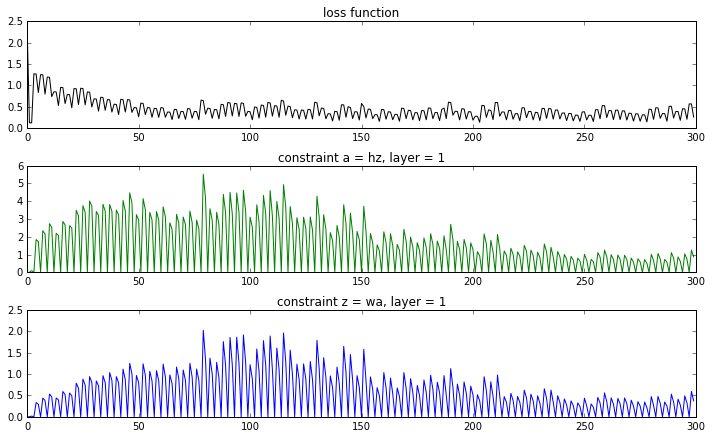

In [14]:
L = len(hiddenLayer)
if calLoss:
    fig = plt.figure()
    gs = gridspec.GridSpec(5,L)

    dataLoss = fig.add_subplot(gs[0,:])
    dataLoss.set_title('loss function')
    dataLoss.plot(network.dataLoss, 'k-')
    
    for l in range(0,L):
        aloss = fig.add_subplot(gs[1,l])
        aloss.set_title('constraint a = hz, layer = %d' % (l+1))
        aloss.plot(network.aConstrLoss[l], 'g-')

        zloss = fig.add_subplot(gs[2,l])
        zloss.set_title('constraint z = wa, layer = %d' % (l+1))
        zloss.plot(network.zConstrLoss[l], 'b-')

#             lag = fig.add_subplot(gs[3,:])
#             lag.set_title('lagrange term')
#             lag.plot(network.lagraLoss, 'r-')

#     evaLoss = fig.add_subplot(gs[3,:])
#     evaLoss.set_title('eval loss')
#     evaLoss.plot(network.evalLoss, 'k-')
    
#     zLLoss = fig.add_subplot(gs[3,:])
#     zLLoss.set_title('output layer zL')
#     zLLoss.plot(network.evalLoss, 'k-')

#     total = fig.add_subplot(gs[4,:])
#     total.set_title('total loss ')
#     total.plot(network.totalLoss, 'r-')

    plt.tight_layout()
    plt.show()